# TTC Delay Forecasting

In [1]:
from config import data_path

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dateutil.parser import parse

import re #for parsing
import time

##import libraries
# from data_load import *

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, GRU, Dense, Concatenate, Input, Flatten
import numpy as np


from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split

2024-12-06 16:45:53.632362: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-06 16:45:53.648678: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-06 16:45:53.653495: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 16:45:53.665768: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-06 16:45:54.452490: W tensorflow/comp

In [2]:
# Defining parsing function
def standardize_time(time_str):
    if len(time_str.split(':')) == 2:  # Format is h:m
        time_str += ':00'
    return time_str

def standardize_time_format(time_str):
    try:
        # Parse the time string
        parsed_time = parse(str(time_str)).time()  # Extract only the time
        # Format to HH:MM:SS
        return parsed_time.strftime('%H:%M:%S')
    except Exception as e:
        print(f"Could not parse '{time_str}': {e}")
        return None
    
def standardize_date_format(date_str):
    try:
        # Parse the date string
        parsed_date = parse(str(date_str)) 
        # Format to YYYY-MM-DD
        return parsed_date.strftime('%Y-%m-%d')
    except Exception as e:
        print(f"Could not parse '{date_str}': {e}")
        return None
    
def parse_string(s):
    # for parsing bus station locations due to faulty data
    try:
        s = s.lower()                   # convert to lowercase
        s = s.replace("station", "stn") # replace "station" with "stn"
        s = s.replace("&", "and")       # replace "&" with "and"
        s = s.replace("centre","center") #other spellings
        s = re.sub(r'\bu\b', 'university', s)
        s = s.replace('stn.','stn')
        s = s.replace("st. clair", "st clair")
        s = s.replace("sta", "station")

        return s
    except Exception as e:
        print(f"Could not parse '{s}': {e}")
        return None



#Defining data loading

def loadRawData(vehicle_type="bus", start_year=2014, end_year=2015, data_path=data_path):
    """
    vehicle_type = bus, subway, streetcar
    start_year = start of year range
    end_year = end of year range
    data_path = path to the data folder
    loads data, based off given parameters
    """
    # Define the subfolder path based on the vehicle type
    subfolder_path = os.path.join(data_path, vehicle_type)

    print('subfolder path', subfolder_path)
    if not os.path.isdir(subfolder_path):
        print("error")
        raise ValueError(f"Subfolder '{vehicle_type}' does not exist in {data_path}.")  # Check if path is correct

    all_data = pd.DataFrame()

    for filename in os.listdir(subfolder_path):
        print("On filename:", filename)

        # Only process relevant files based on the filename structure and year range
        if (
            filename.endswith(".xlsx") and
            filename.startswith(f"ttc-{vehicle_type}-delay-data") and
            start_year <= int(filename.split("-")[-1].split(".")[0]) <= end_year
        ):
            file_path = os.path.join(subfolder_path, filename)
            sheet_names = pd.ExcelFile(file_path).sheet_names
            for month in sheet_names:
                data = pd.read_excel(file_path, sheet_name=month)
                
                # Accounting for inconsistent data formatting and renaming columns as necessary
                if 'Report Date' in data.columns:
                    pass  # Column is already named "Report Date"
                elif 'Date' in data.columns:
                    # Rename 'Date' to 'Report Date'
                    data.rename(columns={'Date': 'Report Date'}, inplace=True)

                if 'Delay' in data.columns:
                    # Rename 'Delay' to 'Min Delay'
                    data.rename(columns={'Delay': 'Min Delay'}, inplace=True)
                elif 'Min Delay' in data.columns:
                    pass  # Column is already named "Min Delay"
                
                # Filter out rows where the "incident" column is "Diversion"
                # dropped on after data exploration

                if 'Incident' in data.columns:
                    data = data[data['Incident'] != 'Diversion']

                # Concatenate the processed data
                all_data = pd.concat([all_data, data], ignore_index=True)

    return all_data


In [3]:
#Defining sliding window function

def create_sliding_windows(df, n_steps, n_outputs, target_column):
    """
    Converts a DataFrame into overlapping sliding windows.

    Parameters:
    - df: Input DataFrame with features and target variable.
    - n_steps: Number of time steps in the input sequence.
    - n_outputs: Number of time steps in the output sequence.
    - target_column: Name or index of the target column.

    Returns:
    - X: Numpy array of shape (num_samples, n_steps, num_features)
    - y: Numpy array of shape (num_samples, n_outputs)
    """
    X, y = [], []
    if isinstance(target_column, str):
        target_index = df.columns.get_loc(target_column)  # Get column index
    else:
        target_index = target_column

    data = df.to_numpy()  # Convert to NumPy for efficiency
    for i in range(len(data) - n_steps - n_outputs + 1):
        # Include all columns except the target in X
        X.append(data[i:i + n_steps, :])
        # Use only the target column for y
        y.append(data[i + n_steps:i + n_steps + n_outputs, target_index])
    X = np.array(X)
    y = np.array(y)

    # Exclude the target column from X (optional if the target is among features)
    # X = np.delete(X, target_index, axis=-1)
    return X, y

In [4]:
''' #code to investigate into the direction column / cardinality
description = df['Direction'].describe()
print("Summary Statistics:\n", description)
unique_values_count = df['Direction'].nunique()
print(len(df['Direction']))
print(f"Number of unique values in 'Location': {unique_values_count}")

import matplotlib.pyplot as plt


# Plot the top 10 most common labels
top_labels = df['Direction'].value_counts().head(50)
top_labels_list = top_labels.index.tolist()
print(top_labels_list)
# for label in top_labels_list:
#      print(label)

top_labels.plot(kind='bar', figsize=(10, 5))

# Set title and labels
plt.title('Direction vs Frequency')
plt.xlabel('Direction')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()
'''
''' #code to investigate the Location column / cardinality:
description = df['Location'].describe()
print("Summary Statistics:\n", description)
unique_values_count = df['Location'].nunique()
print(len(df['Location']))
print(f"Number of unique values in 'Location': {unique_values_count}")

import matplotlib.pyplot as plt


# Plot the top 10 most common labels
top_labels = df['Location'].value_counts().head(1000)
top_labels_list = top_labels.index.tolist()
print(top_labels_list)
# for label in top_labels_list:
#      print(label)

top_labels.plot(kind='bar', figsize=(100, 20))

# Set title and labels
plt.title('Top 500 Most Frequent Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()
'''

' #code to investigate the Location column / cardinality:\ndescription = df[\'Location\'].describe()\nprint("Summary Statistics:\n", description)\nunique_values_count = df[\'Location\'].nunique()\nprint(len(df[\'Location\']))\nprint(f"Number of unique values in \'Location\': {unique_values_count}")\n\nimport matplotlib.pyplot as plt\n\n\n# Plot the top 10 most common labels\ntop_labels = df[\'Location\'].value_counts().head(1000)\ntop_labels_list = top_labels.index.tolist()\nprint(top_labels_list)\n# for label in top_labels_list:\n#      print(label)\n\ntop_labels.plot(kind=\'bar\', figsize=(100, 20))\n\n# Set title and labels\nplt.title(\'Top 500 Most Frequent Labels\')\nplt.xlabel(\'Label\')\nplt.ylabel(\'Frequency\')\nplt.grid(axis=\'y\', linestyle=\'--\', alpha=0.7)\n\n# Show the plot\nplt.show()\n'

In [5]:
#getting data
vehicle_type = 'bus'
start_year = 2014 #min
end_year = 2023 #max

#number of outputs: (how many points ahead to forecast)s

targets = ["Min Delay"]
features = ["Report Date", "Time","Direction", "Location", "Route"]

print("Loading data")
df_raw = loadRawData(vehicle_type=vehicle_type,start_year=start_year,end_year=end_year)

print("Finished loading data")

Loading data
subfolder path /media/jadenh/SSD2/TTC_DATA/bus
On filename: ttc-bus-delay-data-2014.xlsx
On filename: ttc-bus-delay-data-2015.xlsx
On filename: ttc-bus-delay-data-2016.xlsx
On filename: ttc-bus-delay-data-2017.xlsx
On filename: ttc-bus-delay-data-2018.xlsx
On filename: ttc-bus-delay-data-2019.xlsx
On filename: ttc-bus-delay-data-2020.xlsx
On filename: ttc-bus-delay-data-2021.xlsx
On filename: ttc-bus-delay-data-2022.xlsx
On filename: ttc-bus-delay-data-2023.xlsx
On filename: ttc-bus-delay-data-2024.xlsx
Finished loading data


In [6]:
## Defining parameters:
df = df_raw.copy()

n_outputs = 1 #forecasting the next delay
n_steps = 5 # how many points to use # assuming about 4 delays per hour * 24 hours / day ~ 100 points of data.

# However, from testing different n_steps, we found that it may have led to overfitting in LSTM and GRU models.
# For RNN, n_steps should be increased
## Processing Data

#first, sort index
df = df.sort_index() 

print("Using features:\n",features,"\nTargets:",targets)

df = df[targets+features] #only using necessary data
df.dropna(axis=0, how='any', inplace=True) #drops empty rows where any are null  
print("target + features + dropped empty:\n",df.head())


# applying parsing functions to the time and date (due to different formats)
df['Time'] = df['Time'].apply(standardize_time_format)
df['Report Date'] = df['Report Date'].apply(standardize_date_format)
df['Datetime'] = pd.to_datetime((df['Report Date'] + ' ' + df['Time']),format='%Y-%m-%d %H:%M:%S') #combining into one column
df.drop(columns = ['Time','Report Date'], inplace = True)

# preprocessing the DIRECTION to make consistent 4 + 1 directions 
valid_directions = ['n','s','e','w','b'] #should only have n,e,s,w, b - both ways
df['Direction'] = df['Direction'].str[0].str.lower()
df['Direction'] = df['Direction'].apply(lambda x: x if x in valid_directions else 'unknown')

df['Location'] = df['Location'].apply(parse_string)

df['Route'] = df['Route'].astype(str)
## one hot encoding 
# the only one hot encoded feature will be: 'Direction', as determined by the data exploration

one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = one_hot_encoder.fit_transform(df[['Direction']])

one_hot_encoded_df = pd.DataFrame(encoded_features, columns=one_hot_encoder.get_feature_names_out(['Direction']))
df = pd.concat([df, one_hot_encoded_df], axis=1)
df.drop(df[['Direction']], axis=1, inplace=True) #removing unecessary columns


# defining encoders for embedding
location_encoder = LabelEncoder()
route_encoder = LabelEncoder()

## Using label encodings and embeddings: #
df['Location_encoded'] = location_encoder.fit_transform(df['Location'])
df['Route_encoded'] = route_encoder.fit_transform(df['Route'])

df = df.drop('Location',axis=1)
df = df.drop('Route',axis=1)

location_vocab_size = len(location_encoder.classes_)  # Number of unique locations
route_vocab_size = len(route_encoder.classes_)  # Number of unique routes


df.dropna(axis=0, how='any', inplace=True) #drops empty rows where any are null  
df.set_index('Datetime',inplace=True)
# Extract year, month, day, hour, and minute from the Datetime index
df['year'] = df.index.year.astype(int)
df['month'] = df.index.month.astype(int)
df['day'] = df.index.day.astype(int)
df['hour'] = df.index.hour.astype(int)
df['minute'] = df.index.minute.astype(int)



# Add cyclical features for time components
# this allows the model to better understand the cyclical nature of the time features
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)  # Assuming 31 days max
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

df['day_of_year'] = df.index.dayofyear  # The day of the year
df['year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)  # Using 365.25 for leap years
df['year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)

df.drop(columns=['month','day','hour','minute', 'day_of_year'], inplace=True)


# statistics = pd.DataFrame({
#     'max': df[['year', 'month', 'day', 'hour', 'minute']].max(),
#     'min': df[['year', 'month', 'day', 'hour', 'minute']].min(),
#     'std': df[['year', 'month', 'day', 'hour', 'minute']].std()
# })

# print(statistics)
    
scaler = RobustScaler() #because we want model to be robust to outliars of which there are a couple
# scaler = StandardScaler() #standard because we expect standard deviation
# scaler = MinMaxScaler() #min max because ...

df[['Min Delay']] = scaler.fit_transform(df[['Min Delay']])
df.dropna(axis=0, how='any', inplace=True)

print(df.head())

delay_stats = df['Min Delay'].describe()
print("Statistics of the min delay:",delay_stats)

# split the dataframes into training and testing dataframes to avoid data leakage
#splitting data
test_size = 0.2
split_index = int(len(df) * (1 - test_size))

df_train = df.iloc[:split_index]
df_test = df.iloc[split_index:] 

test_size = 0.2
split_index = int(len(df) * (1 - test_size))


X_train, y_train = create_sliding_windows(df_train,n_steps,n_outputs,target_column=targets[0])
X_test, y_test = create_sliding_windows(df_test,n_steps,n_outputs,target_column=targets[0])

print("Finished loading data")

print("x train shape:", X_train.shape)
print("x test shape:", X_test.shape)
print("y train shape:", y_train.shape)
print("y test shape:", y_test.shape)

Using features:
 ['Report Date', 'Time', 'Direction', 'Location', 'Route'] 
Targets: ['Min Delay']
target + features + dropped empty:
    Min Delay Report Date      Time Direction              Location  Route
0       10.0  2014-01-01  00:23:00         E    York Mills station   95.0
1       33.0  2014-01-01  00:55:00       b/w  Entire run for route  102.0
2       10.0  2014-01-01  01:28:00        WB   lawrence and Warden   54.0
3       18.0  2014-01-01  01:30:00         N       Kipling Station  112.0
4       10.0  2014-01-01  01:37:00         n      VP and Ellesmere   24.0
                     Min Delay  Direction_e  Direction_n  Direction_s  \
Datetime                                                                
2014-01-01 00:23:00      0.000          1.0          0.0          0.0   
2014-01-01 00:55:00      2.875          0.0          0.0          0.0   
2014-01-01 01:28:00      0.000          0.0          0.0          0.0   
2014-01-01 01:30:00      1.000          0.0          1.0

In [7]:
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Defining lstm model function to use for hyperparameter tuning
def create_lstm_model(hp):
    # Define the input shapes for time features, location, and route
    n_steps = X_train.shape[1]  # Number of time steps in the sliding window
    n_features = X_train.shape[2] - 2  # Number of features for time inputs

    # Input layers
    features_input = layers.Input(shape=(n_steps, n_features), name='features_input')
    location_input = layers.Input(shape=(n_steps, 1), name='Location_input')
    route_input = layers.Input(shape=(n_steps, 1), name='Route_input')

    # LSTM layers
    # First lstm layer
    lstm_out = layers.LSTM(
        hp.Int('num_neurons_1', min_value=20, max_value=160, step=20), 
        activation='relu', 
        return_sequences=True, #for the 2nd layer to be able to use lstm output
        kernel_regularizer=regularizers.l2(hp.Float('l2_penalty', min_value=1e-4, max_value=1e-2, sampling='LOG'))
    )(features_input)

    lstm_out = layers.BatchNormalization()(lstm_out) #normalize
    lstm_out = layers.Dropout(hp.Float('dropout_rate_1', min_value=0.2, max_value=0.8, step=0.05))(lstm_out)

    # Second lstm layer
    lstm_out = layers.LSTM(
        hp.Int('num_neurons_2', min_value=20, max_value=100, step=20),
        activation='relu', 
        kernel_regularizer=regularizers.l2(hp.Float('l2_penalty', min_value=1e-4, max_value=1e-2, sampling='LOG'))
    )(lstm_out)
    lstm_out = layers.BatchNormalization()(lstm_out)
    lstm_out = layers.Dropout(hp.Float('dropout_rate_1', min_value=0.2, max_value=0.8, step=0.1))(lstm_out)

    # Embedding layers for categorical features (location and route)
    location_embedded = layers.Embedding(input_dim=location_vocab_size, output_dim=hp.Int('location_embedding_dim', min_value=10, max_value=40, step=10))(location_input)
    route_embedded = layers.Embedding(input_dim=route_vocab_size, output_dim=hp.Int('route_embedding_dim', min_value=5, max_value=20, step=5))(route_input)

    location_embedded = layers.Flatten()(location_embedded)
    route_embedded = layers.Flatten()(route_embedded)

    # Concatenate the LSTM output with the embedded categorical features
    x = layers.Concatenate()([lstm_out, location_embedded, route_embedded])

    # Dense layer for final output
    x = layers.Dense(hp.Int('num_neurons_3', min_value=20, max_value=120, step=20), activation='relu')(x)
    # x = layers.BatchNormalization()(x)

    output = layers.Dense(n_outputs)(x)

    # Compile the model with an Adam optimizer, adding gradient clipping
    optimizer = Adam(
        learning_rate=hp.Float('learning_rate', min_value=1e-8, max_value=1e-4, sampling='LOG'),
        clipvalue=1.0  # Gradient clipping to 1 to prevent exploding gradient
    )
    
    model = models.Model(inputs=[features_input, location_input, route_input], outputs=output)
    model.compile(optimizer=optimizer, metrics=['mse', 'mae'], loss='mae') #using MAE as metric: we are looking for delays on average, so this helps to find more average delays

    return model

# Define the ReduceLROnPlateau callback
lr_on_plateau = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,  # Reduce learning rate by half when plateau is detected
    patience=1,  # Wait for 2 epochs before reducing the learning rate
    min_lr=1e-8  # Minimum learning rate
)

# Define the Hyperband Tuner
lstm_tuner = kt.Hyperband(
    create_lstm_model,
    objective='val_loss',
    max_epochs=25,  # Maximum number of epochs per model
    factor=2,  # Reduction factor for resource allocation
    directory='kt_dir',
    project_name='traffic_delay_lstm_hpo_hyperband_sincos'
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Splitting the data into non-embedded features and embedded features based of how the data is structured
X_train_regular = np.concatenate((X_train[:, :, :6], X_train[:, :, 8:]), axis=2)
X_train_location = X_train[:, :, 6:7]
X_train_route = X_train[:, :, 7:8]

batch_size = 256
lstm_tuner.search(
    [X_train_regular, X_train_location, X_train_route], 
    y_train,
    epochs=25,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping, lr_on_plateau],  # Include both early stopping, and lr reduction for plateaus
    shuffle=False
)

# Retrieve the best hyperparameters
lstm_best_hyperparameters = lstm_tuner.oracle.get_best_trials()[0].hyperparameters
print("Best Hyperparameters:", lstm_best_hyperparameters)


Trial 70 Complete [00h 02m 18s]
val_loss: 1.6910051107406616

Best val_loss So Far: 0.7834423184394836
Total elapsed time: 17h 55m 28s

Search: Running Trial #71

Value             |Best Value So Far |Hyperparameter
120               |80                |num_neurons_1
0.00075505        |0.00024037        |l2_penalty
0.45              |0.65              |dropout_rate_1
100               |40                |num_neurons_2
10                |10                |location_embedding_dim
10                |10                |route_embedding_dim
20                |100               |num_neurons_3
1.0748e-08        |6.5734e-05        |learning_rate
13                |7                 |tuner/epochs
0                 |4                 |tuner/initial_epoch
1                 |4                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/13
  17/1320 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 1.1633 - mae: 0.9991 - mse: 1.8937   

2024-12-06 16:51:03.277507: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_fusion_16', 4 bytes spill stores, 4 bytes spill loads



1320/1320 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - loss: 1.1799 - mae: 1.0157 - mse: 2.6076 - val_loss: 1.0189 - val_mae: 0.8548 - val_mse: 3.5179 - learning_rate: 1.0748e-08
Epoch 2/13
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1.1801 - mae: 1.0159 - mse: 2.6096 - val_loss: 1.0180 - val_mae: 0.8538 - val_mse: 3.5182 - learning_rate: 1.0748e-08
Epoch 3/13
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1.1811 - mae: 1.0170 - mse: 2.6171 - val_loss: 1.0176 - val_mae: 0.8536 - val_mse: 3.5173 - learning_rate: 1.0748e-08
Epoch 4/13
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1.1758 - mae: 1.0117 - mse: 2.5927 - val_loss: 1.0165 - val_mae: 0.8524 - val_mse: 3.5172 - learning_rate: 1.0748e-08
Epoch 5/13
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 1.1802 - mae: 1.0162 - mse: 2.6112 - val_loss: 1.0171 - val_mae: 0.8531 - val_mse: 3.5168 - learning_rate: 1.0748e-08
Epoch 6/13
 377/1320 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 1.1590 - mae: 0.9950 - mse: 2.1026

KeyboardInterrupt: 

In [8]:
# Build and train the best model
lstm_best_hyperparameters = lstm_tuner.oracle.get_best_trials()[0].hyperparameters
print("Best Hyperparameters:", lstm_best_hyperparameters.values)
lstm_model = lstm_tuner.hypermodel.build(lstm_best_hyperparameters)
lstm_model.summary()
#storing history for plotting
lstm_history = lstm_model.fit(
    [X_train_regular, X_train_location, X_train_route], 
    y_train,
    epochs=50,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping,lr_on_plateau],
    shuffle=False
)

Best Hyperparameters: {'num_neurons_1': 80, 'l2_penalty': 0.0002403695176648779, 'dropout_rate_1': 0.65, 'num_neurons_2': 40, 'location_embedding_dim': 10, 'route_embedding_dim': 10, 'num_neurons_3': 100, 'learning_rate': 6.573381074675638e-05, 'tuner/epochs': 7, 'tuner/initial_epoch': 4, 'tuner/bracket': 4, 'tuner/round': 2, 'tuner/trial_id': '0020'}


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ features_input      │ (None, 5, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 5, 80)     │     31,360 │ features_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 80)     │        320 │ lstm_2[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 5, 80)     │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 40)        │     19,360 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Location_input      │ (None, 5, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Route_input         │ (None, 5, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40)        │        160 │ lstm_3[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 5, 1, 10)  │    861,420 │ Location_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 5, 1, 10)  │      7,420 │ Route_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 40)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 50)        │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 50)        │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 140)       │          0 │ dropout_3[0][0],  │
│ (Concatenate)       │                   │            │ flatten_2[0][0],  │
│                     │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 100)       │     14,100 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        101 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 934,241 (3.56 MB)

 Trainable params: 934,001 (3.56 MB)

 Non-trainable params: 240 (960.00 B)

Epoch 1/50
  20/1320 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.9374 - mae: 0.9044 - mse: 1.6918   

2024-12-06 16:52:11.710934: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_fusion_14', 4 bytes spill stores, 4 bytes spill loads



1320/1320 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - loss: 0.8005 - mae: 0.7758 - mse: 1.9470 - val_loss: 0.7916 - val_mae: 0.7812 - val_mse: 3.5477 - learning_rate: 6.5734e-05
Epoch 2/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.7084 - mae: 0.6995 - mse: 1.7665 - val_loss: 0.7936 - val_mae: 0.7871 - val_mse: 3.4954 - learning_rate: 6.5734e-05
Epoch 3/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.6927 - mae: 0.6863 - mse: 1.7391 - val_loss: 0.7866 - val_mae: 0.7805 - val_mse: 3.5161 - learning_rate: 3.2867e-05
Epoch 4/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.6861 - mae: 0.6800 - mse: 1.7309 - val_loss: 0.7868 - val_mae: 0.7809 - val_mse: 3.5050 - learning_rate: 3.2867e-05
Epoch 5/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.6825 - mae: 0.6767 - mse: 1.7215 - val_loss: 0.7841 - val_mae: 0.7783 - val_mse: 3.5263 - learning_rate: 1.6433e-05
Epoch 6/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.6807 - mae: 0.6750 - mse: 1.7201 - val_loss

(422189, 5, 17) (422189, 5, 1) (422189, 5, 1) (422189, 1)
(105544, 5, 17) (105544, 5, 1) (105544, 5, 1) (105544, 1)
13194/13194 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - loss: 0.6729 - mae: 0.6674 - mse: 1.8502
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 1.0590 - mae: 1.0535 - mse: 15.2130
Training Metrics:
loss: 0.7029
mae: 0.6974
mse: 2.5798

Testing Metrics:
loss: 1.0155
mae: 1.0100
mse: 12.7756


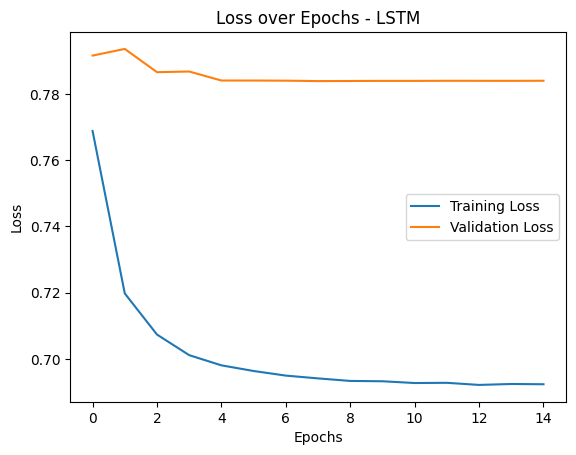

In [9]:
def test_model(model,X_train_regular, X_train_location, X_train_route, X_test_regular, X_test_location, X_test_route,y_train,y_test,history,model_name):
    #Testing model:
    # getting predictions of model:

    print(X_train_regular.shape, X_train_location.shape, X_train_route.shape,y_train.shape)
    print(X_test_regular.shape, X_test_location.shape, X_test_route.shape,y_test.shape)

    # getting training and testing metrics
    train_metrics = model.evaluate(
        [X_train_regular, X_train_location, X_train_route], 
        y_train, 
        verbose=1, 
        return_dict=True
    )
    test_metrics = model.evaluate(
        [X_test_regular, X_test_location, X_test_route], 
        y_test, 
        verbose=1, 
        return_dict=True
    )

    # Print the evaluation results
    print("Training Metrics:")
    for metric, value in train_metrics.items():
        print(f"{metric}: {value:.4f}")

    print("\nTesting Metrics:")
    for metric, value in test_metrics.items():
        print(f"{metric}: {value:.4f}")

    # Plot loss over epochs
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs - '+model_name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


# slicing X_test to get the regular and embedded data 
X_test_regular = np.concatenate((X_test[:, :, :6], X_test[:, :, 8:]), axis=2)
X_test_location = X_test[:, :, 6:7]
X_test_route =X_test[:, :, 7:8]

test_model(lstm_model,
           X_train_regular,
           X_train_location,
           X_train_route,
           X_test_regular,
           X_test_location,
           X_test_route,
           y_train,
           y_test,
           lstm_history,
           model_name = "LSTM")



Predicting for: 15  steps
Step 1/15:
Step 11/15:
Unscaled predictions: [ 8.6094265  9.468393   9.421188   9.796489  10.221924  10.496766
 10.4760475 10.488645  10.48507   10.518498  10.498057  10.477363
 10.48953   10.485484  10.518613 ]
Step 1/15:
Step 11/15:
predictions: [-0.17382163, -0.066450834, -0.07235146, -0.025438918, 0.027740436, 0.06209572, 0.05950598, 0.06108055, 0.060633834, 0.06481226, 0.062257167, 0.059670363, 0.06119122, 0.060685556, 0.064826556]
Plotting predictions vs real delays...
Reversing cyclical features for datetime...
Generated datetime series of length 15.


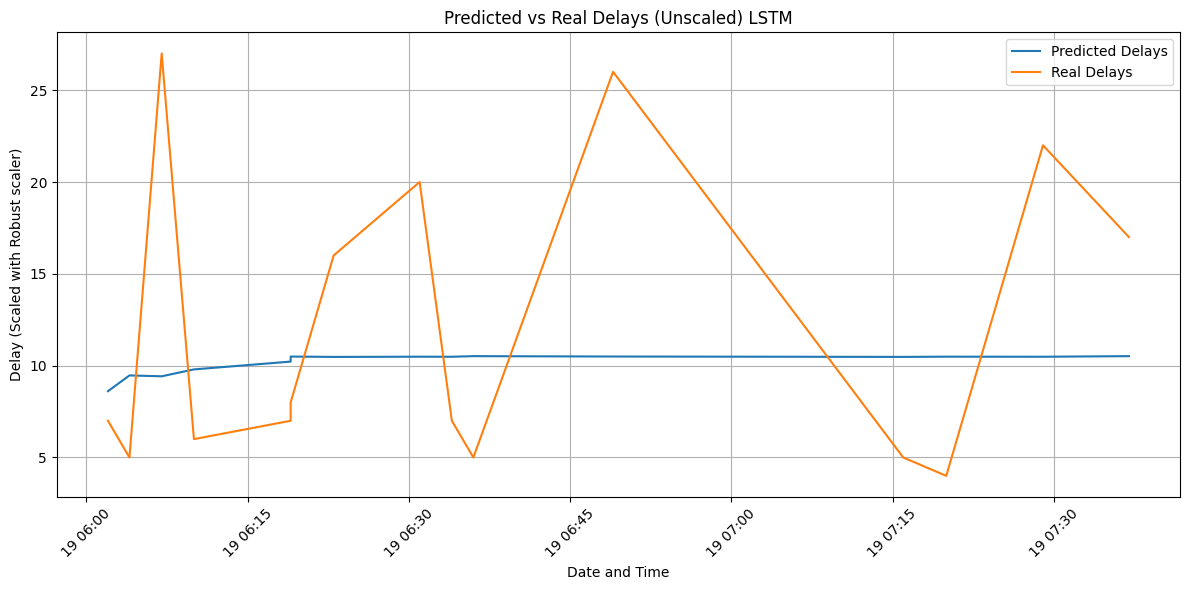

Reversing cyclical features for datetime...
Generated datetime series of length 15.


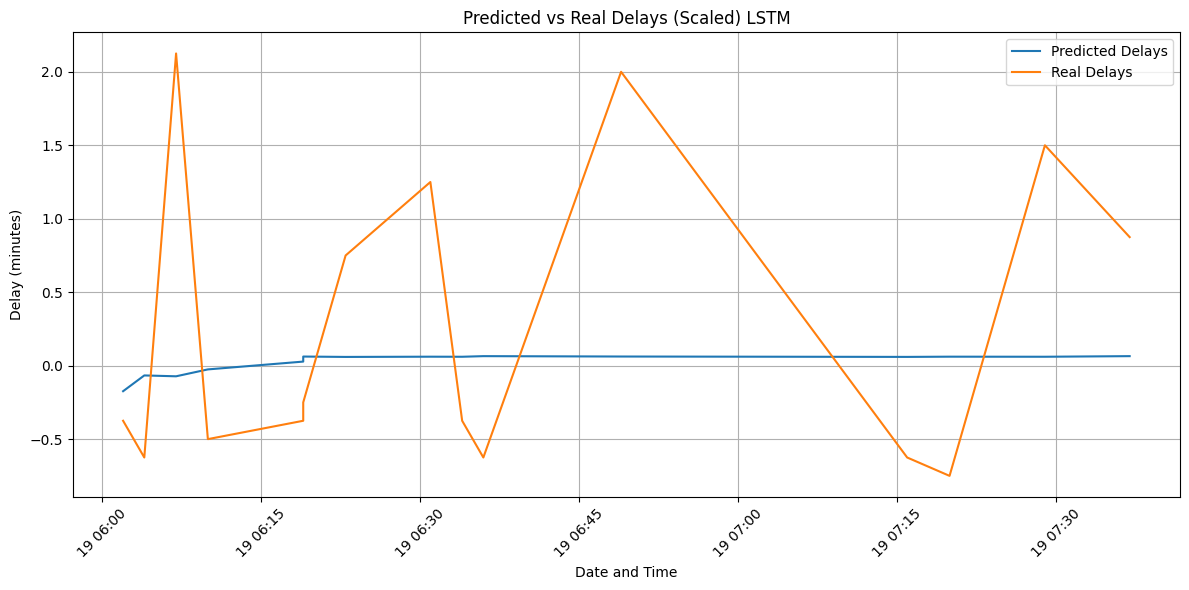

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to forecast delays based off given number of steps
def forecast_next_delays(model, X_test_regular, X_test_location, X_test_route, scaler, steps,unscale = True):

    # Initialize with the last timestep
    last_data_regular = X_test_regular[-1:, :, :]  # Last timestep for regular features
    last_data_location = X_test_location[-1:, :, :]  # Last timestep for location features
    last_data_route = X_test_route[-1:, :, :]  # Last timestep for route features

    predictions = []  # Store predicted delays

    for step in range(steps):
        if step % 10 == 0:
            print(f"Step {step + 1}/{steps}:")

        # Predicting the next delay
        predicted_delay = model.predict([last_data_regular, last_data_location, last_data_route], verbose=0)
        predicted_delay = predicted_delay[0, 0]  # Extract scalar value
        # print(f"  Predicted delay: {predicted_delay}")

        predictions.append(predicted_delay)  # Store the prediction to be used as a feature

        # Prepare for next iteration by sliding the window
        last_data_regular = np.roll(last_data_regular, shift=-1, axis=1)
        last_data_location = np.roll(last_data_location, shift=-1, axis=1)
        last_data_route = np.roll(last_data_route, shift=-1, axis=1)

        # Update the last positions with the new predicted delay
        last_data_regular[0, -1, -1] = predicted_delay
        last_data_location[0, -1, -1] = predicted_delay
        last_data_route[0, -1, -1] = predicted_delay

    # Unscale the predictions for the graph 
    if unscale:
        predictions_unscaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).squeeze()
        print("Unscaled predictions:", predictions_unscaled)
        return predictions_unscaled
    else:
        print("predictions:", predictions)
        return predictions


# Function to reverse cyclical features from cos + sin version to their proper versions
def reverse_cyclical(cyclical_features):
    """
    Converts cyclical features (sin, cos) into datetime components.
    """

    year = cyclical_features[:,0]
    month_sin, month_cos = cyclical_features[:, 1], cyclical_features[:, 2]
    day_sin, day_cos = cyclical_features[:, 3], cyclical_features[:, 4]
    hour_sin, hour_cos = cyclical_features[:, 7], cyclical_features[:, 8]
    minute_sin, minute_cos = cyclical_features[:, 9], cyclical_features[:, 10]

    # Recover datetime components
    month = np.arctan2(month_sin, month_cos) * 12 / (2 * np.pi)
    month = month.round().astype(int)
    month[month < 0] += 12  # Adjust negative values for month due to the way the cyclical works (center at middle)

    day = np.arctan2(day_sin, day_cos) * 31 / (2 * np.pi)
    day = day.round().astype(int)
    day[day < 0] += 31  # Adjust negative values for day

    hour = np.arctan2(hour_sin, hour_cos) * 24 / (2 * np.pi)
    hour = hour.round().astype(int)
    hour[hour < 0] += 24  # Adjust negative values for hour

    minute = np.arctan2(minute_sin, minute_cos) * 60 / (2 * np.pi)
    minute = minute.round().astype(int)
    minute[minute < 0] += 60  # Adjust negative values for minute


    # Ensure bounds
    # print(f"year: {year}")
    # print(f"month: {month}")
    # print(f"day: {day}")
    # print(f"hour: {hour}")
    # print(f"minute: {minute}")

    # Generate datetime series
    datetime_series = pd.to_datetime({
        'year': year,
        'month': month,
        'day': day,
        'hour': hour,
        'minute': minute
    })

    print(f"Generated datetime series of length {len(datetime_series)}.")
    return datetime_series

# Function to plot predictions against real delays
def plot_predictions_vs_real(predicted_delays, real_delays, cyclical_features, n_steps, title, xlabel, ylabel):
    """
    Plots predicted delays against real delays, using reversed cyclical features as timestamps.
    """
    # Validate inputs
    if len(predicted_delays) != len(real_delays):
        raise ValueError("Predicted delays and real delays must have the same length.")

    print("Reversing cyclical features for datetime...")
    datetime_series = reverse_cyclical(cyclical_features)

    # Plot predicted vs real delays
    plt.figure(figsize=(12, 6))
    plt.plot(datetime_series, predicted_delays, label='Predicted Delays')#, marker='o')
    plt.plot(datetime_series, real_delays, label='Real Delays')#, marker='x')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# pred_steps = len(X_test)
pred_steps = 15
print("Predicting for:",pred_steps," steps")

# Forecast the next delays
predicted_delays_unscaled = forecast_next_delays(
    model=lstm_model,
    X_test_regular=X_train_regular,
    X_test_location=X_train_location,
    X_test_route=X_train_route,
    scaler=scaler,
    steps=pred_steps,
    unscale=True,
)

predicted_delays = forecast_next_delays(
    model=lstm_model,
    X_test_regular=X_train_regular,
    X_test_location=X_train_location,
    X_test_route=X_train_route,
    scaler=scaler,
    steps=pred_steps,
    unscale=False,
)

# Extract cyclical features for the last steps
cyclical_features = X_test[:pred_steps, 0, 8:19]

# print(df_test.head(pred_steps))

# Get actual delays for comparison
real_delays = y_test[:pred_steps]
# print("Real delays:",real_delays)
real_delays_unscaled = scaler.inverse_transform(np.array(real_delays).reshape(-1, 1)).squeeze()

print("Plotting predictions vs real delays...")
plot_predictions_vs_real(predicted_delays_unscaled, #unscaled (in minutes)
                         real_delays_unscaled,
                         cyclical_features,
                         pred_steps,
                         xlabel = 'Date and Time',
                         ylabel = 'Delay (Scaled with Robust scaler)',
                         title = 'Predicted vs Real Delays (Unscaled) LSTM')

plot_predictions_vs_real(predicted_delays,
                         real_delays,
                         cyclical_features,
                         pred_steps,
                         xlabel = 'Date and Time',
                         ylabel = 'Delay (minutes)',
                         title = 'Predicted vs Real Delays (Scaled) LSTM') #scaled


In [12]:
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Define a function that creates and compiles the GRU model
def create_gru_model(hp):
    # Define the input shapes for time features, location, and route
    n_steps = X_train.shape[1]  # Number of time steps in the sliding window
    n_features = X_train.shape[2] - 2  # Number of features for time inputs

    # Input layers
    features_input = layers.Input(shape=(n_steps, n_features), name='features_input')
    location_input = layers.Input(shape=(n_steps, 1), name='Location_input')
    route_input = layers.Input(shape=(n_steps, 1), name='Route_input')

    # GRU layers
    gru_out = layers.GRU(
        hp.Int('num_neurons_1', min_value=20, max_value=160, step=20),
        activation='relu',
        return_sequences=True,
        kernel_regularizer=regularizers.l2(hp.Float('l2_penalty', min_value=1e-4, max_value=1e-2, sampling='LOG'))
    )(features_input)

    gru_out = layers.BatchNormalization()(gru_out)
    gru_out = layers.Dropout(hp.Float('dropout_rate_1', min_value=0.2, max_value=0.8, step=0.05))(gru_out)

    gru_out = layers.GRU(
        hp.Int('num_neurons_2', min_value=20, max_value=100, step=20),
        activation='relu',
        kernel_regularizer=regularizers.l2(hp.Float('l2_penalty', min_value=1e-4, max_value=1e-2, sampling='LOG'))
    )(gru_out)
    gru_out = layers.BatchNormalization()(gru_out)
    gru_out = layers.Dropout(hp.Float('dropout_rate_2', min_value=0.2, max_value=0.8, step=0.1))(gru_out)

    # Embedding layers for categorical features (location and route)
    location_embedded = layers.Embedding(input_dim=location_vocab_size, output_dim=hp.Int('location_embedding_dim', min_value=10, max_value=40, step=10))(location_input)
    route_embedded = layers.Embedding(input_dim=route_vocab_size, output_dim=hp.Int('route_embedding_dim', min_value=5, max_value=20, step=5))(route_input)

    location_embedded = layers.Flatten()(location_embedded)
    route_embedded = layers.Flatten()(route_embedded)

    # Concatenate the GRU output with the embedded categorical features
    x = layers.Concatenate()([gru_out, location_embedded, route_embedded])

    # Dense layer for final output
    x = layers.Dense(hp.Int('num_neurons_3', min_value=20, max_value=120, step=20), activation='relu')(x)

    output = layers.Dense(n_outputs)(x)

    # Compile the model with an Adam optimizer, adding gradient clipping
    optimizer = Adam(
        learning_rate=hp.Float('learning_rate', min_value=1e-8, max_value=1e-4, sampling='LOG'),
        clipvalue=1.0  # Gradient clipping by value, set to 1.0 or any other value that suits your needs
    )
    
    model = models.Model(inputs=[features_input, location_input, route_input], outputs=output)
    model.compile(optimizer=optimizer, metrics=['mse', 'mae'], loss='mae')

    return model

# Define the ReduceLROnPlateau callback
lr_on_plateau = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,  # Reduce learning rate by half when plateau is detected
    patience=1,  # Wait for 2 epochs before reducing the learning rate
    min_lr=1e-8  # Minimum learning rate
)

# Define the Hyperband Tuner
gru_tuner = kt.Hyperband(
    create_gru_model,
    objective='val_loss',
    max_epochs=25,  # Maximum number of epochs per model
    factor=2,  # Reduction factor for resource allocation
    directory='kt_dir',
    project_name='traffic_delay_gru_hpo_hyperband_sincos'
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Splitting the data into non-embedded features and embedded features
X_train_regular = np.concatenate((X_train[:, :, :6], X_train[:, :, 8:]), axis=2)
X_train_location = X_train[:, :, 6:7]
X_train_route = X_train[:, :, 7:8]

# Define batch_size as a hyperparameter in the search space
batch_size = 256

# Perform the search with the ReduceLROnPlateau callback
gru_tuner.search(
    [X_train_regular, X_train_location, X_train_route], 
    y_train,
    epochs=25,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping, lr_on_plateau],  # Include both early stopping and ReduceLROnPlateau
    shuffle=False
)

# Retrieve the best hyperparameters
gru_best_hyperparameters = gru_tuner.oracle.get_best_trials()[0].hyperparameters
print("Best Hyperparameters:", gru_best_hyperparameters)


Trial 54 Complete [00h 00m 46s]
val_loss: 0.8303623199462891

Best val_loss So Far: 0.7873533964157104
Total elapsed time: 15h 01m 17s

Search: Running Trial #55

Value             |Best Value So Far |Hyperparameter
80                |40                |num_neurons_1
0.00030842        |0.00092422        |l2_penalty
0.45              |0.35              |dropout_rate_1
40                |100               |num_neurons_2
0.4               |0.6               |dropout_rate_2
20                |20                |location_embedding_dim
20                |5                 |route_embedding_dim
20                |100               |num_neurons_3
2.3122e-07        |2.9182e-05        |learning_rate
7                 |13                |tuner/epochs
4                 |7                 |tuner/initial_epoch
3                 |4                 |tuner/bracket
1                 |3                 |tuner/round
0048              |0030              |tuner/trial_id

Epoch 5/7


2024-12-06 17:09:47.161365: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_fusion_16', 4 bytes spill stores, 4 bytes spill loads



KeyboardInterrupt: 

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ features_input      │ (None, 5, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 5, 40)     │      7,080 │ features_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 40)     │        160 │ gru_2[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 5, 40)     │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_3 (GRU)         │ (None, 100)       │     42,600 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Location_input      │ (None, 5, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Route_input         │ (None, 5, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100)       │        400 │ gru_3[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 5, 1, 20)  │  1,722,840 │ Location_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 5, 1, 5)   │      3,710 │ Route_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 100)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 100)       │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 25)        │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 225)       │          0 │ dropout_3[0][0],  │
│ (Concatenate)       │                   │            │ flatten_2[0][0],  │
│                     │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 100)       │     22,600 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        101 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,799,491 (6.86 MB)

 Trainable params: 1,799,211 (6.86 MB)

 Non-trainable params: 280 (1.09 KB)

Epoch 1/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - loss: 0.9670 - mae: 0.8869 - mse: 2.2129 - val_loss: 1.1264 - val_mae: 1.0748 - val_mse: 3.9592 - learning_rate: 2.9182e-05
Epoch 2/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.7802 - mae: 0.7348 - mse: 1.8314 - val_loss: 1.1858 - val_mae: 1.1550 - val_mse: 4.2345 - learning_rate: 2.9182e-05
Epoch 3/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.7456 - mae: 0.7166 - mse: 1.7877 - val_loss: 0.8664 - val_mae: 0.8420 - val_mse: 3.5001 - learning_rate: 1.4591e-05
Epoch 4/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.7318 - mae: 0.7087 - mse: 1.7751 - val_loss: 0.8171 - val_mae: 0.7975 - val_mse: 3.5016 - learning_rate: 1.4591e-05
Epoch 5/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.7208 - mae: 0.7020 - mse: 1.7619 - val_loss: 0.8043 - val_mae: 0.7879 - val_mse: 3.5433 - learning_rate: 1.4591e-05
Epoch 6/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.7124 - mae: 0.6966 - mse: 1.7

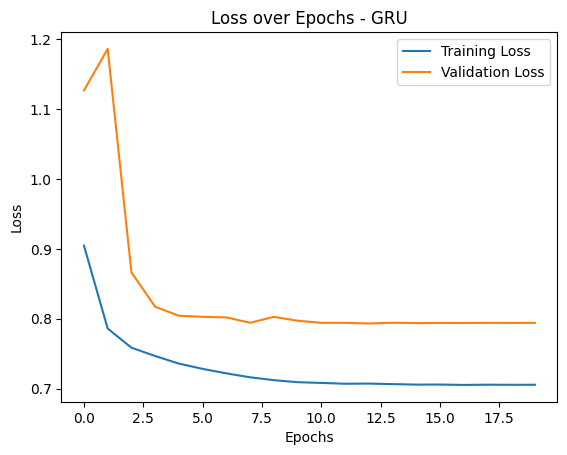

In [13]:
# Build and train the best model
gru_best_hyperparameters = gru_tuner.oracle.get_best_trials()[0].hyperparameters
gru_model = gru_tuner.hypermodel.build(gru_best_hyperparameters)

gru_model.summary()

gru_history = gru_model.fit(
    [X_train_regular, X_train_location, X_train_route], 
    y_train,
    epochs=50,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping, lr_on_plateau],
    shuffle=False
)


# Testing gru model
test_model(gru_model,
           X_train_regular,
           X_train_location,
           X_train_route,
           X_test_regular,
           X_test_location,
           X_test_route,
           y_train,
           y_test,
           gru_history,
           model_name = "GRU")

Predicting for: 15  steps
Step 1/15:
Step 11/15:
Unscaled predictions: [10.81687   11.383632  10.85682   11.232418  10.021713  11.068975
 11.33086   11.207994  11.252752  10.070899  11.091111  11.332959
 11.218699  11.25509   10.0725155]
Step 1/15:
Step 11/15:
predictions: [0.102108695, 0.17295401, 0.10710255, 0.15405227, 0.0027141375, 0.13362192, 0.16635753, 0.15099935, 0.156594, 0.008862327, 0.13638891, 0.16661994, 0.15233748, 0.15688618, 0.009064416]
Plotting predictions vs real delays...
Reversing cyclical features for datetime...
Generated datetime series of length 15.


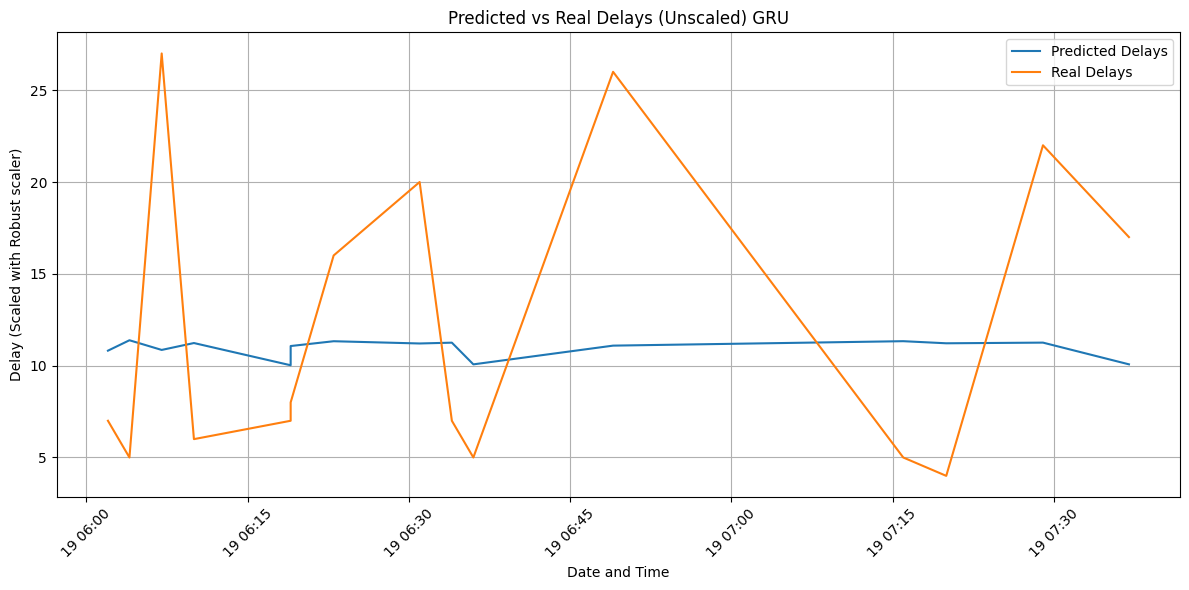

Reversing cyclical features for datetime...
Generated datetime series of length 15.


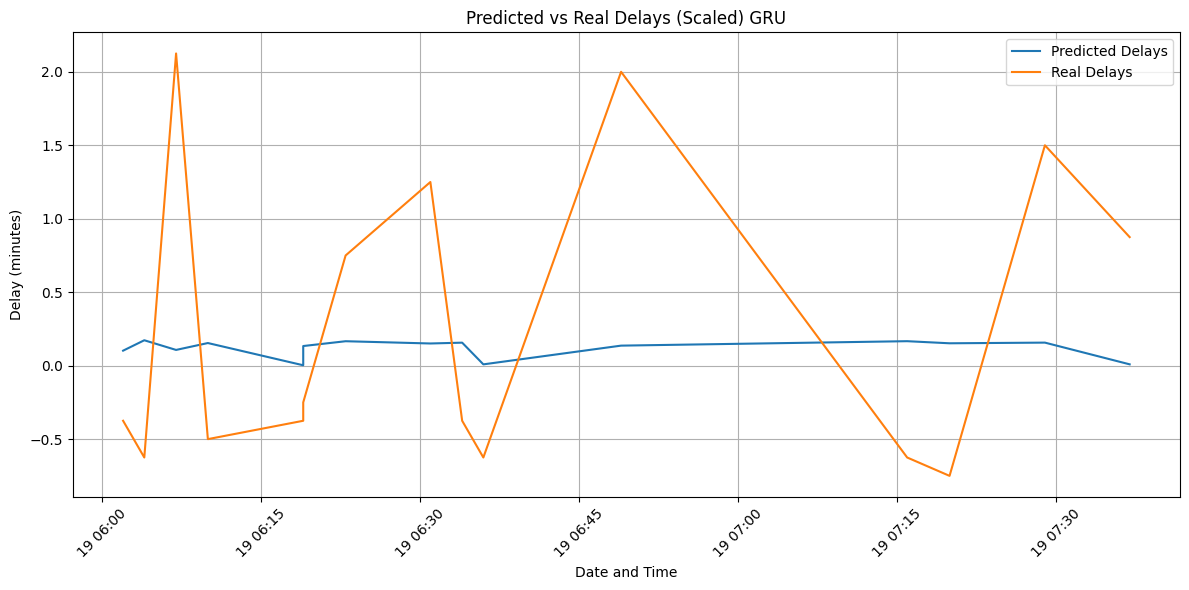

In [14]:
# Forecasting for GRU model

pred_steps = 15
print("Predicting for:",pred_steps," steps")

# Forecast the next delays
predicted_delays_unscaled = forecast_next_delays(
    model=gru_model,
    X_test_regular=X_train_regular,
    X_test_location=X_train_location,
    X_test_route=X_train_route,
    scaler=scaler,
    steps=pred_steps,
    unscale=True,
)

predicted_delays = forecast_next_delays(
    model=gru_model,
    X_test_regular=X_train_regular,
    X_test_location=X_train_location,
    X_test_route=X_train_route,
    scaler=scaler,
    steps=pred_steps,
    unscale=False,
)


cyclical_features = X_test[:pred_steps, 0, 8:19]

# print(df_test.head(pred_steps))

# Get actual delays for comparison
real_delays = y_test[:pred_steps]
# print("Real delays:",real_delays)
real_delays_unscaled = scaler.inverse_transform(np.array(real_delays).reshape(-1, 1)).squeeze()

print("Plotting predictions vs real delays...")
plot_predictions_vs_real(predicted_delays_unscaled, #unscaled (in minutes)
                         real_delays_unscaled,
                         cyclical_features,
                         pred_steps,
                         xlabel = 'Date and Time',
                         ylabel = 'Delay (Scaled with Robust scaler)',
                         title = 'Predicted vs Real Delays (Unscaled) GRU')

plot_predictions_vs_real(predicted_delays,
                         real_delays,
                         cyclical_features,
                         pred_steps,
                         xlabel = 'Date and Time',
                         ylabel = 'Delay (minutes)',
                         title = 'Predicted vs Real Delays (Scaled) GRU') #scaled

In [18]:
# Define a function that creates and compiles the RNN model
def create_rnn_model(hp):
    # Define the input shapes for time features, location, and route
    n_steps = X_train.shape[1]  # Number of time steps in the sliding window
    n_features = X_train.shape[2] - 2  # Number of features for time inputs

    # Input layers
    features_input = layers.Input(shape=(n_steps, n_features), name='features_input')
    location_input = layers.Input(shape=(n_steps, 1), name='Location_input')
    route_input = layers.Input(shape=(n_steps, 1), name='Route_input')

    # RNN layers
    rnn_out = layers.SimpleRNN(
        hp.Int('num_neurons_1', min_value=20, max_value=160, step=20),
        activation='relu',
        return_sequences=True,
        kernel_regularizer=regularizers.l2(hp.Float('l2_penalty', min_value=1e-4, max_value=1e-2, sampling='LOG'))
    )(features_input)

    rnn_out = layers.BatchNormalization()(rnn_out)
    rnn_out = layers.Dropout(hp.Float('dropout_rate_1', min_value=0.2, max_value=0.8, step=0.05))(rnn_out)

    rnn_out = layers.SimpleRNN(
        hp.Int('num_neurons_2', min_value=20, max_value=100, step=20),
        activation='relu',
        kernel_regularizer=regularizers.l2(hp.Float('l2_penalty', min_value=1e-4, max_value=1e-2, sampling='LOG'))
    )(rnn_out)
    rnn_out = layers.BatchNormalization()(rnn_out)
    rnn_out = layers.Dropout(hp.Float('dropout_rate_2', min_value=0.2, max_value=0.8, step=0.1))(rnn_out)

    # Embedding layers for categorical features (location and route)
    location_embedded = layers.Embedding(input_dim=location_vocab_size, output_dim=hp.Int('location_embedding_dim', min_value=10, max_value=40, step=10))(location_input)
    route_embedded = layers.Embedding(input_dim=route_vocab_size, output_dim=hp.Int('route_embedding_dim', min_value=5, max_value=20, step=5))(route_input)

    location_embedded = layers.Flatten()(location_embedded)
    route_embedded = layers.Flatten()(route_embedded)

    # Concatenate the RNN output with the embedded categorical features
    x = layers.Concatenate()([rnn_out, location_embedded, route_embedded])

    # Dense layer for final output
    x = layers.Dense(hp.Int('num_neurons_3', min_value=20, max_value=120, step=20), activation='relu')(x)

    output = layers.Dense(n_outputs)(x)

    # Compile the model with an Adam optimizer, adding gradient clipping
    optimizer = Adam(
        learning_rate=hp.Float('learning_rate', min_value=1e-8, max_value=1e-4, sampling='LOG'),
        clipvalue=1.0  # Gradient clipping by value, set to 1.0 or any other value that suits your needs
    )
    
    model = models.Model(inputs=[features_input, location_input, route_input], outputs=output)
    model.compile(optimizer=optimizer, metrics=['mse', 'mae'], loss='mae')

    return model


# Define the ReduceLROnPlateau callback
lr_on_plateau = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,  # Reduce learning rate by half when plateau is detected
    patience=1,  # Wait for 2 epochs before reducing the learning rate
    min_lr=1e-8  # Minimum learning rate
)

# Define the Hyperband Tuner
rnn_tuner = kt.Hyperband(
    create_rnn_model,
    objective='val_loss',
    max_epochs=25,  # Maximum number of epochs per model
    factor=2,  # Reduction factor for resource allocation
    directory='kt_dir',
    project_name='traffic_delay_rnn_hpo_hyperband_sincos'
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Splitting the data into non-embedded features and embedded features based of how the data is structured
X_train_regular = np.concatenate((X_train[:, :, :6], X_train[:, :, 8:]), axis=2)
X_train_location = X_train[:, :, 6:7]
X_train_route = X_train[:, :, 7:8]

batch_size = 256
rnn_tuner.search(
    [X_train_regular, X_train_location, X_train_route], 
    y_train,
    epochs=25,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping, lr_on_plateau],  # Include both early stopping, and lr reduction for plateaus
    shuffle=False
)

# Retrieve the best hyperparameters
rnn_best_hyperparameters = rnn_tuner.oracle.get_best_trials()[0].hyperparameters
print("Best Hyperparameters:", rnn_best_hyperparameters)


Trial 32 Complete [00h 00m 41s]
val_loss: 0.8092553019523621

Best val_loss So Far: 0.7946353554725647
Total elapsed time: 00h 17m 45s

Search: Running Trial #33

Value             |Best Value So Far |Hyperparameter
120               |160               |num_neurons_1
0.00031543        |0.0001192         |l2_penalty
0.4               |0.5               |dropout_rate_1
60                |20                |num_neurons_2
0.4               |0.2               |dropout_rate_2
30                |10                |location_embedding_dim
15                |15                |route_embedding_dim
120               |120               |num_neurons_3
7.7916e-06        |1.8663e-08        |learning_rate
7                 |7                 |tuner/epochs
4                 |4                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
2                 |2                 |tuner/round
0022              |0020              |tuner/trial_id

Epoch 5/7
1320/1320 ━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

a


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ features_input      │ (None, 5, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_2        │ (None, 5, 160)    │     28,480 │ features_input[0… │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 160)    │        640 │ simple_rnn_2[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 5, 160)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_3        │ (None, 20)        │      3,620 │ dropout_2[0][0]   │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Location_input      │ (None, 5, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Route_input         │ (None, 5, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20)        │         80 │ simple_rnn_3[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 5, 1, 10)  │    861,420 │ Location_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 5, 1, 15)  │     11,130 │ Route_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 20)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 50)        │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 75)        │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 145)       │          0 │ dropout_3[0][0],  │
│ (Concatenate)       │                   │            │ flatten_2[0][0],  │
│                     │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 120)       │     17,520 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        121 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 923,011 (3.52 MB)

 Trainable params: 922,651 (3.52 MB)

 Non-trainable params: 360 (1.41 KB)

Epoch 1/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 0.7466 - mae: 0.7388 - mse: 1.8012 - val_loss: 0.7970 - val_mae: 0.7892 - val_mse: 3.5952 - learning_rate: 1.8663e-08
Epoch 2/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.7467 - mae: 0.7389 - mse: 1.7977 - val_loss: 0.7971 - val_mae: 0.7893 - val_mse: 3.5956 - learning_rate: 1.8663e-08
Epoch 3/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.7465 - mae: 0.7387 - mse: 1.7994 - val_loss: 0.7970 - val_mae: 0.7893 - val_mse: 3.5955 - learning_rate: 1.0000e-08
Epoch 4/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.7473 - mae: 0.7395 - mse: 1.8014 - val_loss: 0.7974 - val_mae: 0.7896 - val_mse: 3.5970 - learning_rate: 1.0000e-08
Epoch 5/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.7453 - mae: 0.7375 - mse: 1.7967 - val_loss: 0.7969 - val_mae: 0.7891 - val_mse: 3.5950 - learning_rate: 1.0000e-08
Epoch 6/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.7472 - mae: 0.7394 - mse: 1.8

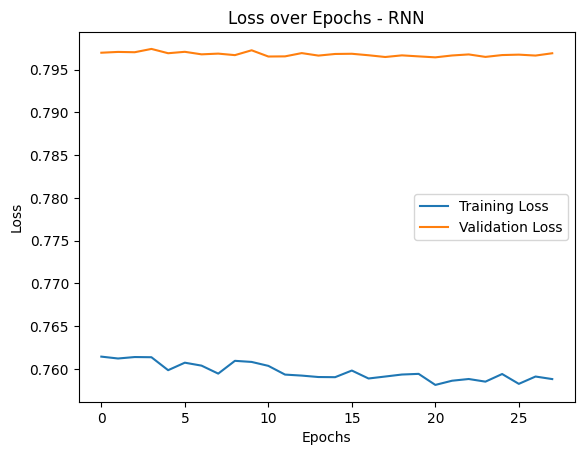

In [19]:
# Build and train the best model
print('a')
rnn_best_hyperparameters = rnn_tuner.oracle.get_best_trials()[0].hyperparameters
rnn_model = rnn_tuner.hypermodel.build(rnn_best_hyperparameters)

rnn_model.summary()


# Train the RNN model
rnn_history = rnn_model.fit(
    [X_train_regular, X_train_location, X_train_route], 
    y_train,
    epochs=50,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping, lr_on_plateau],
    shuffle=False
)

# Testing the RNN model
test_model(
    rnn_model,
    X_train_regular,
    X_train_location,
    X_train_route,
    X_test_regular,
    X_test_location,
    X_test_route,
    y_train,
    y_test,
    rnn_history,
    model_name="RNN"
)


Predicting for: 15  steps
Step 1/15:
Step 11/15:
Unscaled predictions: [ 9.646352   9.572479  10.421328   9.736535   9.662635   9.998839
 10.009663  10.047856   9.947615  10.002992   9.998938  10.0091505
 10.047175   9.947678  10.003238 ]
Step 1/15:
Step 11/15:
predictions: [-0.044206, -0.05344006, 0.052666, -0.03293313, -0.042170648, -0.00014508965, 0.0012077756, 0.005982048, -0.006548182, 0.00037395506, -0.0001328409, 0.0011438235, 0.005896977, -0.0065402454, 0.0004047092]
Plotting predictions vs real delays...
Reversing cyclical features for datetime...
Generated datetime series of length 15.


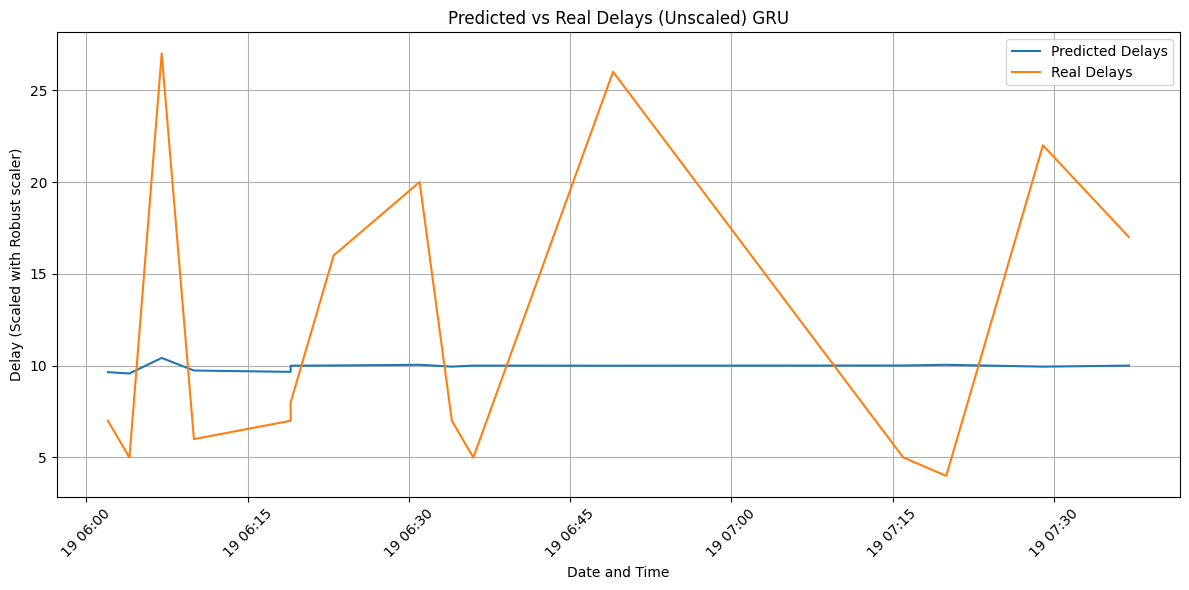

Reversing cyclical features for datetime...
Generated datetime series of length 15.


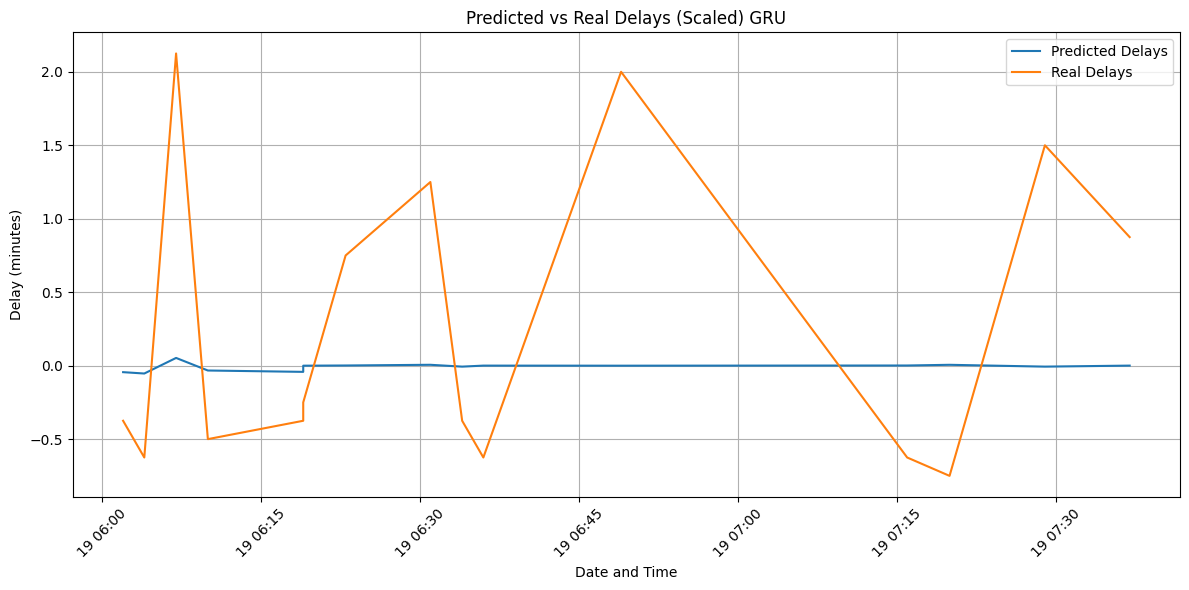

In [20]:
# Forecasting for GRU model

pred_steps = 15
print("Predicting for:",pred_steps," steps")

# Forecast the next delays
predicted_delays_unscaled = forecast_next_delays(
    model=rnn_model,
    X_test_regular=X_train_regular,
    X_test_location=X_train_location,
    X_test_route=X_train_route,
    scaler=scaler,
    steps=pred_steps,
    unscale=True,
)

predicted_delays = forecast_next_delays(
    model=rnn_model,
    X_test_regular=X_train_regular,
    X_test_location=X_train_location,
    X_test_route=X_train_route,
    scaler=scaler,
    steps=pred_steps,
    unscale=False,
)


cyclical_features = X_test[:pred_steps, 0, 8:19]

# print(df_test.head(pred_steps))

# Get actual delays for comparison
real_delays = y_test[:pred_steps]
# print("Real delays:",real_delays)
real_delays_unscaled = scaler.inverse_transform(np.array(real_delays).reshape(-1, 1)).squeeze()

print("Plotting predictions vs real delays...")
plot_predictions_vs_real(predicted_delays_unscaled, #unscaled (in minutes)
                         real_delays_unscaled,
                         cyclical_features,
                         pred_steps,
                         xlabel = 'Date and Time',
                         ylabel = 'Delay (Scaled with Robust scaler)',
                         title = 'Predicted vs Real Delays (Unscaled) GRU')

plot_predictions_vs_real(predicted_delays,
                         real_delays,
                         cyclical_features,
                         pred_steps,
                         xlabel = 'Date and Time',
                         ylabel = 'Delay (minutes)',
                         title = 'Predicted vs Real Delays (Scaled) GRU') #scaled